# Natural Disasters and Growth; A Lasso Approach

In [2]:
import sys
import os
import time
import datetime

import json
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import halfnorm
import openpyxl
from IPython.display import Image

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm


# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scipy version: ' + sp.__version__)
print('### Pandas version: ' + pd.__version__)
print('### Matplotlib version: ' + matplotlib.__version__)
print('### Scikit Learn version: ' + sklearn.__version__)


print('------------')

Group Project -- names: Hunter Becker, Mason Pitts, Alexander Dai, Daniel Kaplan, emails: hbecker1@ufl.edu, masonpitts@ufl.edu, danielkaplan@ufl.edu, alexanderdai@ufl.edu

### Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
### Numpy version: 1.20.3
### Scipy version: 1.7.1
### Pandas version: 1.3.4
### Matplotlib version: 3.4.3
### Scikit Learn version: 0.24.2
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 69

# deterministic seed for reproducibility
np.random.seed(seed)

In [4]:
#Get working directory

location = os.getcwd()

# Temperature and Precipitation
Monthly data on temperature and precipitation. We generate annual measures of temperature and precipitation by averaging monthly observations.

In [5]:
#Precipiataion dataframes

pr_1961_1990 = pd.read_csv(location + r'\pr_1961_1990.csv', skipinitialspace = True)
pr_1991_2020 = pd.read_csv(location + r'\pr_1991_2020.csv', skipinitialspace = True)

#Temperature dataframes

tas_1961_1990 = pd.read_csv(location + r'\tas_1961_1990.csv', skipinitialspace = True)
tas_1991_2020 = pd.read_csv(location + r'\tas_1991_2020.csv', skipinitialspace = True)

In [6]:
#Mean Rainfall by year and country
pr_1961_1990_avg = pr_1961_1990.groupby(["Year", "ISO3"]).mean().reset_index()
pr_1991_2020_avg = pr_1991_2020.groupby(["Year", "ISO3"]).mean().reset_index()

#Mean Temperature by year and country
tas_1961_1990_avg = tas_1961_1990.groupby(["Year", "ISO3"]).mean().reset_index()
tas_1991_2020_avg = tas_1991_2020.groupby(["Year", "ISO3"]).mean().reset_index()

In [7]:
#Average Rainfall Dataset

pr_1961_2020_avg = pd.concat([pr_1961_1990_avg, pr_1991_2020_avg])

#Average Temperature Dataset

tas_1961_2020_avg = pd.concat([tas_1961_1990_avg, tas_1991_2020_avg])

# Natural Disasters (EM-DAT)
The International disasters database provides information on the occurrence and effects of natural disasters.

In [10]:
#Natural Disasters

nat_dis_df = pd.read_excel(location + r'\nat_disasters.xlsx')

In [11]:
#Natural Disaster features of interest

nat_dis_df = nat_dis_df[['Year', 'ISO', 'Disaster Type', 'Total Affected']]

# GDP and Population (WDI)
World Development Indicators (WDI) is the primary World Bank collection of development indicators, which include GDP and population.

In [13]:
#GDP per capita and Population

gdp_pop_df = pd.read_csv(location + r'\World_Development_Indicators.csv')

#GDP and Population Dataframe

gdp_pop_df = gdp_pop_df[['Country_Code', 'Time', 'Total_Population', 'GDP per capita (constant 2015 US$)']]

#Replacing ".." with NaN
gdp_pop_df = gdp_pop_df.replace('..', np.nan)

In [14]:
#Converts all data to numerical values instead of objects or strings
#The index [:, 1:] is needed to avoid applying the numeric function to the "Country_Code" column
gdp_pop_df.iloc[:, 1:] = gdp_pop_df.iloc[:, 1:].apply(pd.to_numeric)

#Drops Nan of GDP per capita
#This dropna() is required since we must have GDP numbers to calculate lagged GDP variables
gdp_pop_df = gdp_pop_df.dropna()

**Getting Income Level of Countries**

In [16]:
# Low Income Countries
lowIncome = pd.read_table(location + r'\Income_Levels\Low_Income.csv', header=0, delimiter=',')
lowIncome = lowIncome.rename(columns={"Time": "Year", "Country Name": "Country"})
lowIncome = lowIncome[['Year','Country', 'Country Code']] # Same Order
lowIncome['Income_Type'] = 'Low Income' # Create new column
lowIncome.head()

# Lower Middle Income Countries
lowMiddleIncome = pd.read_table(location + r'\Income_Levels\Lower_Middle_Income.csv', header=0, delimiter=',')
lowMiddleIncome = lowMiddleIncome.rename(columns={"Time": "Year", "Country Name": "Country"})
lowMiddleIncome = lowMiddleIncome[['Year','Country', 'Country Code']]
lowMiddleIncome['Income_Type'] = 'Lower Middle Income'

# Upper Middle Income Countries
upeMiddleIncome = pd.read_table(location + r'\Income_Levels\Upper_Middle_Income.csv', header=0, delimiter=',')
upeMiddleIncome = upeMiddleIncome.rename(columns={"Time": "Year", "Country Name": "Country"})
upeMiddleIncome = upeMiddleIncome[['Year','Country', 'Country Code']]
upeMiddleIncome['Income_Type'] = 'Upper Middle Income'

# High Income Countries
highIncome = pd.read_table(location + r'\Income_Levels\High_Income.csv', header=0, delimiter=',')
highIncome = highIncome.rename(columns={"Time": "Year", "Country Name": "Country"})
highIncome = highIncome[['Year','Country', 'Country Code']] # Same Order
highIncome['Income_Type'] = 'High Income'

In [17]:
# Unify Datasets
countryType = pd.concat([lowIncome, lowMiddleIncome, upeMiddleIncome, highIncome], axis=0)
countryType = countryType.sort_values(by=['Country', 'Year'])
countryType = countryType.drop(columns=["Country"])

In [19]:
#Merging Income Level and GDP datasets
gdp_pop_df = pd.merge(gdp_pop_df, countryType,  how='left', left_on=['Country_Code','Time'], right_on = ['Country Code','Year'])

In [20]:
#Backfilling Income Data by country
#dropna() should remove data that is not a single country i.e., it removes "WLD" which indicates the entire world economy
#not just a single country
gdp_pop_df = gdp_pop_df.groupby(["Country_Code"]).bfill().drop(columns=["Year"]).dropna()

**Generating Lagged GDP per capita by year and conutry**

In [21]:
#Log of GDP
gdp_pop_df["ln_GDP_2015"] = np.log(gdp_pop_df["GDP per capita (constant 2015 US$)"])

In [22]:
#First difference
gdp_pop_df["ln_GDP_diff"] = gdp_pop_df.groupby(["Country Code"], sort=False)["ln_GDP_2015"].diff(1)

In [23]:
#Lagged differences
gdp_pop_df["ln_GDP_diff_lag1"] = gdp_pop_df.groupby(["Country Code"], sort=False)["ln_GDP_diff"].shift(1)
gdp_pop_df["ln_GDP_diff_lag2"] = gdp_pop_df.groupby(["Country Code"], sort=False)["ln_GDP_diff"].shift(2)

In [25]:
#Renaming GDP variable
gdp_pop_df = gdp_pop_df.rename(columns={"GDP per capita (constant 2015 US$)": "GDP_capita_const_2015"})

In [26]:
#drop Nan, should drop first three observations from each country
gdp_pop_df = gdp_pop_df.dropna()

# Merging Natural Disaster Data with GDP per capita and Population

In [27]:
wdi_em_df = pd.merge(nat_dis_df, gdp_pop_df,  how='left', left_on=['ISO','Year'], right_on = ['Country Code','Time'])

In [28]:
#Dropping Duplicated Columns
wdi_em_df.drop(columns=["Time", "Country Code"], axis=1, inplace=True)

# Merging into Final Dataset
In this section we combine the above three sets of data into a single data set.

In [29]:
#Combining temperature and rainfall

pr_tas = pd.merge(tas_1961_2020_avg, pr_1961_2020_avg,  how='left', left_on=['ISO3','Year'], right_on = ['ISO3','Year'])

In [30]:
data = pd.merge(wdi_em_df, pr_tas,  how='left', left_on=['ISO','Year'], right_on = ['ISO3','Year'])

In [31]:
data = data.rename(columns={"Temperature - (Celsius)": "Avg Temperature (C)", "Rainfall - (MM)": "Avg Rainfall (MM)"})

In [32]:
data.drop(columns=["ISO3"], axis=1, inplace=True)

# Calculating Total Affected

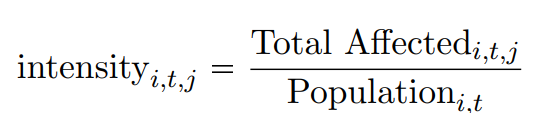

In [33]:
Image(filename = location + "\\total_affected.png", width=400, height=100)

**Creating Disaster Indicators**

Type 1 Disaster: Flood

Type 2 Disaster: Drought, Extreme Temperature, Wildfire

In [34]:
data["Disaster Type"].unique()

array(['Storm', 'Drought', 'Earthquake', 'Landslide', 'Flood',
       'Extreme temperature', 'Volcanic activity', 'Epidemic', 'Wildfire',
       'Mass movement (dry)', 'Insect infestation', 'Impact',
       'Animal accident'], dtype=object)

In [35]:
data["Disaster Indicator"] = data["Disaster Type"].replace({'Flood': 1, 'Drought': 2, 'Extreme temperature': 2, 'Wildfire': 2, 'Earthquake': 0,\
                             'Landslide': 0, 'Storm': 0, 'Volcanic activity': 0, 'Epidemic': 0,\
                             'Mass movement (dry)': 0, 'Insect infestation': 0, 'Impact': 0, 'Animal accident': 0})

In [36]:
#Removes all disasters that are not type 1 or 2

dis_filter = [1, 2]

data = data[data['Disaster Indicator'].isin(dis_filter)]

In [37]:
# Sums the Total Affected for the same disaster type by year and country
data = data.dropna()
data['Sum of Total Affected'] = data.groupby(["Year", "ISO", "Disaster Indicator"])["Total Affected"].transform('sum')

In [38]:
# Calculating the intensity of each disaster

data["Intensity"] = data["Sum of Total Affected"] / data["Total_Population"].astype(float)

In [39]:
data = data.reindex(['Year','ISO', 'Income_Type','Avg Temperature (C)', 'Avg Rainfall (MM)', 'Disaster Indicator', 'Total Affected', 'Total_Population', 'Intensity', 
                     'GDP_capita_const_2015','ln_GDP_2015', 'ln_GDP_diff', 'ln_GDP_diff_lag1', 'ln_GDP_diff_lag2'], axis=1)

In [40]:
#Sorting data by Country and Year

data = data.sort_values(by=["ISO", "Year"])

In [41]:
data = data.reset_index().drop(columns=["index"])

In [42]:
# Removes Total Affected that are zero
# The Nan are converted to zeros when they are divided in the intensity measure above
data = data[data["Total Affected"] != 0]

In [43]:
data = data.drop_duplicates(["Year", "ISO", "Disaster Indicator"])

# 1. 2 Regressions without IV

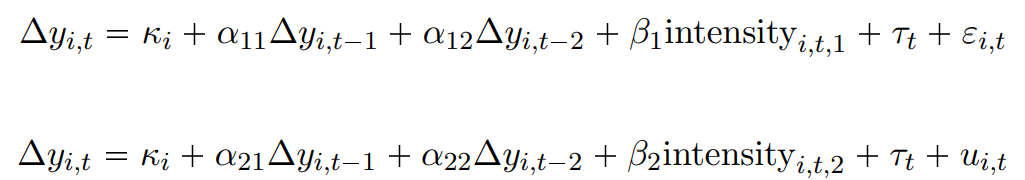

In [44]:
Image(filename = location + "\\reg_model.png", width=800, height=100)

**Splitting Data by Disaster Type and Income Level**

In [45]:
# Split data by natural disaster type
data_1 = data[data["Disaster Indicator"] == 1].dropna()
data_2 = data[data["Disaster Indicator"] == 2].dropna()

#Income Level
#Type 1
high_income_1 = data_1[(data_1["Income_Type"] == "High Income") | (data_1["Income_Type"] == "Upper Middle Income")]
low_income_1 = data_1[(data_1["Income_Type"] == "Low Income") | (data_1["Income_Type"] == "Lower Middle Income")]

#Type 2
high_income_2 = data_2[(data_2["Income_Type"] == "High Income") | (data_2["Income_Type"] == "Upper Middle Income")]
low_income_2 = data_2[(data_2["Income_Type"] == "Low Income") | (data_2["Income_Type"] == "Lower Middle Income")]

# Flood Regression Type 1

**All Countries**

In [46]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((data_1[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(data_1['Year']),\
               pd.get_dummies(data_1['ISO'])), axis=1)

In [47]:
model = sm.OLS(data_1["ln_GDP_diff"], X)

In [48]:
results = model.fit()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     4.190
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           1.84e-65
Time:                        19:31:48   Log-Likelihood:                 4044.8
No. Observations:                2199   AIC:                            -7656.
Df Residuals:                    1982   BIC:                            -6420.
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity           -0.0444      0.028     -1.591      0.112      -0.099       0.010
ln_GDP_diff_lag1     0.1423      0.021      6.672      0.000       0.100       0.184
ln_GDP_diff_lag2     0.1447      0.019      7.474      0.000       0.107       0.183
1964                 0.0188      0.016      1.202      0.230      -0.012       0.049
1965                 0.0149      0.015      1.022      0.307      -0.014       0.044
1966                 0.0027      0.011      0.242      0.809      -0.019       0.024
1967                 0.0129      0.010      1.238      0.216      -0.008       0.033
1968                 0.0168      0.015      1.151      0.250      -0.012       0.045
1969                 0.0235      0.015      1.582      0.114      -0.006       0.053
1970                 0.0173      0.012      1.450      0.147      -0.006       0.041
1971                 0.0137      0.016      0.865      0.387      -0.017       0.045
1972                 0.0357      0.017      2.110      0.035       0.003       0.069
1973                 0.0228      0.013      1.820      0.069      -0.002       0.047
1974                 0.0294      0.014      2.161      0.031       0.003       0.056
1975                 0.0218      0.015      1.498      0.134      -0.007       0.050
1976                 0.0228      0.015      1.565      0.118      -0.006       0.051
1977                 0.0120      0.009      1.269      0.205      -0.007       0.031
1978                 0.0045      0.009      0.488      0.626      -0.014       0.023
1979                -0.0013      0.009     -0.147      0.883      -0.018       0.016
1980                -0.0070      0.009     -0.761      0.447      -0.025       0.011
1981                 0.0021      0.011      0.194      0.846      -0.019       0.024
1982                -0.0265      0.009     -3.076      0.002      -0.043      -0.010
1983                -0.0127      0.009     -1.437      0.151      -0.030       0.005
1984                 0.0094      0.010      0.944      0.345      -0.010       0.029
1985                -0.0033      0.008     -0.400      0.689      -0.019       0.013
1986                 0.0064      0.008      0.808      0.419      -0.009       0.022
1987                 0.0076      0.009      0.866      0.387      -0.010       0.025
1988                 0.0087      0.007      1.221      0.222      -0.005       0.023
1989                -0.0135      0.009     -1.455      0.146      -0.032       0.005
1990                -0.0039      0.008     -0.486      0.627      -0.020       0.012
1991                 0.0022      0.008      0.266      0.791      -0.014       0.018
1992                -0.0037      0.008     -0.458      0.647      -0.019       0.012
1993                -0.0003      0.006     -0.048      0.962      -0.013       0.012
1994                 0.

**High Income Countries**

In [50]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((high_income_1[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(high_income_1['Year']),\
               pd.get_dummies(high_income_1['ISO'])), axis=1)

In [51]:
model = sm.OLS(high_income_1["ln_GDP_diff"], X)

In [52]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     4.530
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           2.26e-44
Time:                        19:31:48   Log-Likelihood:                 2128.8
No. Observations:                1035   AIC:                            -3974.
Df Residuals:                     893   BIC:                            -3272.
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity           -0.0525      0.037     -1.427      0.154      -0.125       0.020
ln_GDP_diff_lag1     0.1533      0.026      5.797      0.000       0.101       0.205
ln_GDP_diff_lag2     0.1566      0.023      6.796      0.000       0.111       0.202
1964                 0.0061      0.020      0.309      0.758      -0.033       0.045
1965                 0.0080      0.014      0.576      0.565      -0.019       0.035
1966                 0.0150      0.014      1.089      0.277      -0.012       0.042
1967                 0.0120      0.011      1.053      0.292      -0.010       0.034
1968                 0.0414      0.034      1.219      0.223      -0.025       0.108
1969                 0.0218      0.018      1.242      0.215      -0.013       0.056
1970                 0.0264      0.012      2.180      0.029       0.003       0.050
1971                 0.0212      0.014      1.505      0.133      -0.006       0.049
1972                 0.0491      0.017      2.872      0.004       0.016       0.083
1973                 0.0304      0.014      2.192      0.029       0.003       0.058
1974                 0.0211      0.024      0.885      0.376      -0.026       0.068
1975                -0.0006      0.019     -0.029      0.977      -0.039       0.038
1976                 0.0102      0.034      0.302      0.763      -0.056       0.077
1977                 0.0161      0.011      1.418      0.156      -0.006       0.038
1978                 0.0144      0.011      1.348      0.178      -0.007       0.035
1979                 0.0280      0.011      2.586      0.010       0.007       0.049
1980                 0.0004      0.010      0.037      0.970      -0.019       0.020
1981                -0.0085      0.013     -0.660      0.509      -0.034       0.017
1982                -0.0381      0.011     -3.544      0.000      -0.059      -0.017
1983                -0.0030      0.010     -0.295      0.768      -0.023       0.017
1984                 0.0295      0.012      2.487      0.013       0.006       0.053
1985                -0.0114      0.011     -1.057      0.291      -0.032       0.010
1986                 0.0213      0.008      2.564      0.011       0.005       0.038
1987                 0.0140      0.009      1.620      0.106      -0.003       0.031
1988                 0.0194      0.009      2.245      0.025       0.002       0.036
1989                -0.0429      0.015     -2.842      0.005      -0.073      -0.013
1990                -0.0061      0.009     -0.644      0.519      -0.024       0.012
1991                 0.0053      0.010      0.501      0.616      -0.015       0.026
1992                 0.0060      0.010      0.605      0.545      -0.014       0.026
1993                -0.0042      0.007     -0.598      0.550      -0.018       0.010
1994                 0.

**Low Income Countries**

In [53]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((low_income_1[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(low_income_1['Year']),\
               pd.get_dummies(low_income_1['ISO'])), axis=1)

In [54]:
model = sm.OLS(low_income_1["ln_GDP_diff"], X)

In [55]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     3.322
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           6.06e-27
Time:                        19:31:49   Log-Likelihood:                 2018.2
No. Observations:                1164   AIC:                            -3770.
Df Residuals:                    1031   BIC:                            -3098.
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity           -0.0246      0.042     -0.591      0.555      -0.106       0.057
ln_GDP_diff_lag1     0.1176      0.034      3.499      0.000       0.052       0.184
ln_GDP_diff_lag2     0.1422      0.031      4.530      0.000       0.081       0.204
1964                 0.0245      0.023      1.070      0.285      -0.020       0.069
1965                 0.0311      0.033      0.957      0.339      -0.033       0.095
1966                -0.0106      0.016     -0.651      0.515      -0.042       0.021
1967                 0.0093      0.018      0.526      0.599      -0.025       0.044
1968                 0.0085      0.017      0.487      0.627      -0.026       0.043
1969                 0.0204      0.023      0.880      0.379      -0.025       0.066
1970                -0.0048      0.023     -0.207      0.836      -0.050       0.040
1971                -0.0427      0.046     -0.937      0.349      -0.132       0.047
1972                 0.0051      0.032      0.157      0.875      -0.059       0.069
1973                 0.0100      0.021      0.482      0.630      -0.031       0.051
1974                 0.0242      0.018      1.371      0.171      -0.010       0.059
1975                 0.0318      0.021      1.543      0.123      -0.009       0.072
1976                 0.0195      0.017      1.120      0.263      -0.015       0.054
1977                 0.0051      0.015      0.354      0.724      -0.023       0.034
1978                -0.0090      0.015     -0.618      0.537      -0.037       0.020
1979                -0.0275      0.013     -2.122      0.034      -0.053      -0.002
1980                -0.0242      0.016     -1.478      0.140      -0.056       0.008
1981                 0.0061      0.017      0.352      0.725      -0.028       0.040
1982                -0.0219      0.013     -1.715      0.087      -0.047       0.003
1983                -0.0256      0.014     -1.847      0.065      -0.053       0.002
1984                -0.0125      0.015     -0.815      0.415      -0.043       0.018
1985                -0.0024      0.012     -0.203      0.839      -0.025       0.021
1986                -0.0208      0.014     -1.493      0.136      -0.048       0.007
1987                -0.0110      0.018     -0.616      0.538      -0.046       0.024
1988                -0.0033      0.011     -0.310      0.756      -0.024       0.018
1989                -0.0066      0.012     -0.550      0.582      -0.030       0.017
1990                -0.0057      0.013     -0.442      0.659      -0.031       0.019
1991                -0.0027      0.012     -0.227      0.820      -0.026       0.021
1992                -0.0147      0.012     -1.237      0.216      -0.038       0.009
1993                 0.0009      0.011      0.081      0.935      -0.020       0.022
1994                -0.

# Heat Disaster Regression Type 2

**All Countries**

In [56]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((data_2[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(data_2['Year']), pd.get_dummies(data_2['ISO'])), axis=1)


In [57]:
model = sm.OLS(data_2["ln_GDP_diff"], X)

In [58]:
results = model.fit()

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     3.085
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           1.76e-23
Time:                        19:31:49   Log-Likelihood:                 1441.2
No. Observations:                 700   AIC:                            -2516.
Df Residuals:                     517   BIC:                            -1683.
Df Model:                         182                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity           -0.0063      0.013     -0.483      0.629      -0.032       0.019
ln_GDP_diff_lag1     0.2352      0.043      5.482      0.000       0.151       0.320
ln_GDP_diff_lag2    -0.0329      0.037     -0.883      0.378      -0.106       0.040
1964                 0.0436      0.020      2.172      0.030       0.004       0.083
1965                 0.0038      0.017      0.222      0.824      -0.030       0.037
1966                 0.0152      0.026      0.579      0.563      -0.036       0.067
1967                 0.0418      0.037      1.145      0.253      -0.030       0.114
1968                 0.0049      0.017      0.286      0.775      -0.029       0.038
1969                -0.0135      0.016     -0.834      0.405      -0.045       0.018
1970                 0.0647      0.027      2.352      0.019       0.011       0.119
1971                 0.0609      0.019      3.177      0.002       0.023       0.098
1972                 0.0074      0.019      0.393      0.695      -0.030       0.045
1974                 0.0330      0.039      0.855      0.393      -0.043       0.109
1975                 0.0151      0.038      0.401      0.688      -0.059       0.089
1976                 0.0953      0.020      4.660      0.000       0.055       0.135
1977                 0.0095      0.024      0.396      0.692      -0.038       0.057
1978                -0.0158      0.016     -1.002      0.317      -0.047       0.015
1979                 0.0010      0.015      0.065      0.948      -0.028       0.030
1980                -0.0069      0.012     -0.573      0.567      -0.031       0.017
1981                -0.0211      0.021     -1.023      0.307      -0.062       0.019
1982                -0.0037      0.019     -0.193      0.847      -0.041       0.034
1983                -0.0448      0.012     -3.871      0.000      -0.068      -0.022
1984                -0.0079      0.022     -0.352      0.725      -0.052       0.036
1985                 0.0035      0.015      0.234      0.815      -0.026       0.033
1986                 0.0099      0.017      0.584      0.560      -0.023       0.043
1987                 0.0243      0.011      2.283      0.023       0.003       0.045
1988                 0.0254      0.014      1.858      0.064      -0.001       0.052
1989                -0.0038      0.017     -0.222      0.824      -0.037       0.029
1990                -0.0093      0.010     -0.957      0.339      -0.029       0.010
1991                 0.0271      0.013      2.015      0.044       0.001       0.054
1992                -0.0154      0.014     -1.133      0.258      -0.042       0.011
1993                -0.0381      0.014     -2.675      0.008      -0.066      -0.010
1994                 0.0068      0.012      0.555      0.579      -0.017       0.031
1995                 0.

**High Income Countries**

In [60]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((high_income_2[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(high_income_2['Year']), pd.get_dummies(high_income_2['ISO'])), axis=1)


In [61]:
model = sm.OLS(high_income_2["ln_GDP_diff"], X)

In [62]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     5.615
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           6.10e-28
Time:                        19:31:49   Log-Likelihood:                 840.08
No. Observations:                 334   AIC:                            -1456.
Df Residuals:                     222   BIC:                            -1029.
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity            0.0148      0.022      0.668      0.505      -0.029       0.058
ln_GDP_diff_lag1     0.4094      0.056      7.256      0.000       0.298       0.521
ln_GDP_diff_lag2     0.0309      0.057      0.541      0.589      -0.082       0.143
1964                 0.0354      0.018      1.950      0.052      -0.000       0.071
1965                 0.0004      0.027      0.015      0.988      -0.053       0.054
1966                 0.0336      0.025      1.363      0.174      -0.015       0.082
1967                 0.0438      0.024      1.790      0.075      -0.004       0.092
1968                 0.0213      0.015      1.451      0.148      -0.008       0.050
1969                 0.0118      0.025      0.477      0.634      -0.037       0.061
1970                 0.0552      0.019      2.939      0.004       0.018       0.092
1975                 0.0024      0.026      0.095      0.925      -0.048       0.053
1978                 0.0325      0.025      1.303      0.194      -0.017       0.082
1979                 0.0317      0.025      1.260      0.209      -0.018       0.081
1980                 0.0027      0.024      0.111      0.911      -0.045       0.051
1981                -0.0035      0.021     -0.165      0.869      -0.045       0.038
1982                 0.0169      0.026      0.660      0.510      -0.034       0.068
1983                -0.0681      0.011     -6.031      0.000      -0.090      -0.046
1984                 0.0215      0.026      0.831      0.407      -0.030       0.073
1985                 0.0083      0.012      0.711      0.478      -0.015       0.031
1986                 0.0040      0.013      0.312      0.756      -0.021       0.029
1987                 0.0191      0.013      1.508      0.133      -0.006       0.044
1988                 0.0172      0.017      0.986      0.325      -0.017       0.052
1989                 0.0561      0.036      1.573      0.117      -0.014       0.126
1990                -0.0104      0.013     -0.801      0.424      -0.036       0.015
1991                 0.0029      0.014      0.198      0.843      -0.026       0.031
1992                 0.0096      0.012      0.830      0.407      -0.013       0.032
1993                -0.0123      0.013     -0.953      0.342      -0.038       0.013
1994                -0.0087      0.011     -0.809      0.420      -0.030       0.012
1995                 0.0162      0.008      1.998      0.047       0.000       0.032
1996                 0.0027      0.013      0.204      0.839      -0.023       0.029
1997                 0.0151      0.010      1.565      0.119      -0.004       0.034
1998                -0.0131      0.008     -1.724      0.086      -0.028       0.002
1999                 0.0135      0.008      1.709      0.089      -0.002       0.029
2000                 0.

**Low Income Countries**

In [63]:
# Creating the explanatory variables and generating dummy variables
X = pd.concat((low_income_2[["Intensity", "ln_GDP_diff_lag1", "ln_GDP_diff_lag2"]], pd.get_dummies(low_income_2['Year']), pd.get_dummies(low_income_2['ISO'])), axis=1)

In [64]:
model = sm.OLS(low_income_2["ln_GDP_diff"], X)

In [65]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_GDP_diff   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1.986
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           3.47e-06
Time:                        19:31:49   Log-Likelihood:                 705.36
No. Observations:                 366   AIC:                            -1171.
Df Residuals:                     246   BIC:                            -702.4
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intensity           -0.0315      0.019     -1.666      0.097      -0.069       0.006
ln_GDP_diff_lag1     0.1333      0.072      1.861      0.064      -0.008       0.274
ln_GDP_diff_lag2    -0.0693      0.056     -1.233      0.219      -0.180       0.041
1964                 0.0398      0.036      1.105      0.270      -0.031       0.111
1965                 0.0130      0.023      0.563      0.574      -0.032       0.058
1966                -0.0171      0.045     -0.379      0.705      -0.106       0.072
1968                -0.0241      0.033     -0.738      0.461      -0.089       0.040
1969                -0.0107      0.022     -0.486      0.627      -0.054       0.033
1971                 0.0610      0.023      2.640      0.009       0.015       0.107
1972                 0.0061      0.023      0.269      0.788      -0.039       0.051
1974                 0.0249      0.047      0.536      0.593      -0.067       0.117
1976                 0.0991      0.025      3.953      0.000       0.050       0.149
1977                 0.0078      0.029      0.271      0.787      -0.049       0.065
1978                -0.0283      0.021     -1.356      0.176      -0.070       0.013
1979                -0.0108      0.019     -0.562      0.574      -0.049       0.027
1980                -0.0038      0.016     -0.246      0.806      -0.035       0.027
1981                -0.0634      0.037     -1.732      0.084      -0.135       0.009
1982                -0.0070      0.026     -0.267      0.789      -0.058       0.044
1983                -0.0199      0.019     -1.033      0.302      -0.058       0.018
1984                -0.0272      0.033     -0.829      0.408      -0.092       0.037
1985                -0.0007      0.036     -0.019      0.985      -0.071       0.070
1986                 0.0192      0.045      0.428      0.669      -0.069       0.108
1987                 0.0210      0.016      1.335      0.183      -0.010       0.052
1988                 0.0238      0.019      1.241      0.216      -0.014       0.062
1989                -0.0207      0.022     -0.951      0.342      -0.063       0.022
1990                -0.0045      0.014     -0.331      0.741      -0.031       0.022
1991                 0.0402      0.021      1.949      0.052      -0.000       0.081
1992                -0.0487      0.027     -1.799      0.073      -0.102       0.005
1993                -0.0570      0.026     -2.170      0.031      -0.109      -0.005
1994                 0.0158      0.023      0.700      0.485      -0.029       0.060
1995                 0.0254      0.029      0.860      0.391      -0.033       0.083
1996                 0.0095      0.025      0.378      0.706      -0.040       0.059
1997                -0.0078      0.016     -0.495      0.621      -0.039       0.023
1998                -0.

# 1.3 LASSO and Instrumental Variable Approach

### Polynomials of Temperature and Precipitation

In [66]:
#Calculating polynomials by using Polynomial Features
polyf = PolynomialFeatures(degree= 4, include_bias = False)
#Creates independents out of the variables needed
independents1 = pd.DataFrame()
independents1 = data_1[['Avg Temperature (C)', 'Avg Rainfall (MM)']]
independents2 = pd.DataFrame()
independents2 = data_2[['Avg Temperature (C)', 'Avg Rainfall (MM)']]
#Generating polynomials from independents
data_1polys = polyf.fit_transform(independents1.copy())
data_2polys = polyf.fit_transform(independents2.copy())

In [67]:
# Check to ensure polynomials were created correctly
theNames = polyf.get_feature_names(independents1.columns)
print(theNames)

['Avg Temperature (C)', 'Avg Rainfall (MM)', 'Avg Temperature (C)^2', 'Avg Temperature (C) Avg Rainfall (MM)', 'Avg Rainfall (MM)^2', 'Avg Temperature (C)^3', 'Avg Temperature (C)^2 Avg Rainfall (MM)', 'Avg Temperature (C) Avg Rainfall (MM)^2', 'Avg Rainfall (MM)^3', 'Avg Temperature (C)^4', 'Avg Temperature (C)^3 Avg Rainfall (MM)', 'Avg Temperature (C)^2 Avg Rainfall (MM)^2', 'Avg Temperature (C) Avg Rainfall (MM)^3', 'Avg Rainfall (MM)^4']


### Projection matrix used to remove time fixed effects and country fixed effects from the explanatory variables and the dependent varaible

In [68]:
#Year Dummies
year_dummies_1 = pd.get_dummies(data_1['Year'], prefix='y')
year_dummies_2 = pd.get_dummies(data_2['Year'], prefix='y')

In [69]:
#Country Dummies
country_dummies_1 = pd.get_dummies(data_1['ISO'])
country_dummies_2 = pd.get_dummies(data_2['ISO'])

In [70]:
#Fixed Effect Dummies
dummies_type_1 = pd.concat([year_dummies_1, country_dummies_1], axis=1)
dummies_type_2 = pd.concat([year_dummies_2, country_dummies_2], axis=1)

In [71]:
# Creating Matrices for fixed effect dummy variables
dum_CT1 = dummies_type_1.values
dum_CT2 = dummies_type_2.values

### Projection matrix is defined as: $CTdum(CTdum^TCTdum)^{-1}CTdum^T$

The project matrix in this case will remove the time fixed effects and the country fixed effects from the
explanatory variables and the intentisty measure.

In [72]:
# This removes the affects generated by year and country

projectionMatrix_1 = dum_CT1@np.linalg.inv(dum_CT1.T@dum_CT1)@dum_CT1.T

projectionMatrix_2 = dum_CT2@np.linalg.inv(dum_CT2.T@dum_CT2)@dum_CT2.T

In [73]:
#Type 1 in Matrices
intensity_1 = data_1["Intensity"].values.reshape(-1,1)

#Type 2 in Matrices
intensity_2 = data_2["Intensity"].values.reshape(-1,1)

In [74]:
#Type 1 removing the fixed effects of years and country
dependent_noCTdummy_1 = intensity_1 - projectionMatrix_1@intensity_1

indpendent_noCTdummy_1 = data_1polys - projectionMatrix_1@data_1polys

#Type 2 removing the fixed effects of country
dependent_noCTdummy_2 = intensity_2 - projectionMatrix_2@intensity_2

indpendent_noCTdummy_2 = data_2polys - projectionMatrix_2@data_2polys

**Creating dataframes for temperature, precipitation, and intensity with fixed effects removed**

In [75]:
#Type 1 Data
newData_noCTdummy_1 = pd.DataFrame()
newData_noCTdummy_1[theNames] = indpendent_noCTdummy_1
newData_noCTdummy_1["Intensity"] = dependent_noCTdummy_1 

newData_noCTdummy_1.head()

,Avg Temperature (C),Avg Rainfall (MM),Avg Temperature (C)^2,Avg Temperature (C) Avg Rainfall (MM),Avg Rainfall (MM)^2,Avg Temperature (C)^3,Avg Temperature (C)^2 Avg Rainfall (MM),Avg Temperature (C) Avg Rainfall (MM)^2,Avg Rainfall (MM)^3,Avg Temperature (C)^4,Avg Temperature (C)^3 Avg Rainfall (MM),Avg Temperature (C)^2 Avg Rainfall (MM)^2,Avg Temperature (C) Avg Rainfall (MM)^3,Avg Rainfall (MM)^4,Intensity
0,17.369238,59.907845,365.026755,778.951876,5083.463196,8376.257700,13841.592360,65498.088182,1.125000e+06,211653.410860,283873.927414,9.763797e+05,2.049731e+07,4.037611e+08,0.002832
1,17.877734,72.614746,438.220231,1352.909290,10709.785405,10805.046338,33887.403342,240414.761464,2.699722e+06,281295.440126,875794.189129,6.107916e+06,6.590073e+07,7.987709e+08,0.028357
2,-0.379427,-7.875195,20.485396,-436.680956,198.173391,981.752730,-7958.875337,-5675.613071,9.102713e+05,44564.977876,-128165.558869,1.889597e+05,2.252067e+07,4.221151e+08,0.007775
3,3.972786,-1.860221,118.170287,-386.661930,-2873.203505,3402.911893,-6905.393425,-84724.406840,-4.326427e+05,108435.552897,-92064.725345,-1.718201e+06,-1.028024e+07,-1.305241e+07,0.012323
4,1.916797,13.839518,93.422566,150.181434,4072.431726,2880.397371,6440.076886,91353.068491,1.699721e+06,92021.591172,219436.029203,2.534664e+06,4.172339e+07,6.132771e+08,0.015677


In [76]:
#Type 2 Data
newData_noCTdummy_2 = pd.DataFrame()
newData_noCTdummy_2[theNames] = indpendent_noCTdummy_2
newData_noCTdummy_2["Intensity"] = dependent_noCTdummy_2 

newData_noCTdummy_2.head()

,Avg Temperature (C),Avg Rainfall (MM),Avg Temperature (C)^2,Avg Temperature (C) Avg Rainfall (MM),Avg Rainfall (MM)^2,Avg Temperature (C)^3,Avg Temperature (C)^2 Avg Rainfall (MM),Avg Temperature (C) Avg Rainfall (MM)^2,Avg Rainfall (MM)^3,Avg Temperature (C)^4,Avg Temperature (C)^3 Avg Rainfall (MM),Avg Temperature (C)^2 Avg Rainfall (MM)^2,Avg Temperature (C) Avg Rainfall (MM)^3,Avg Rainfall (MM)^4,Intensity
0,-2.501042,9.755469,-9.417109,1412.680469,15633.667628,345.360566,46339.624723,5.075338e+05,4.897682e+06,3.738958e+03,1.357100e+06,1.441466e+07,1.382989e+08,1.289091e+09,-0.165954
1,-41.896094,-156.241146,-1615.776191,-6365.816131,-48467.267925,-43685.740882,-182653.600241,-1.308947e+06,-1.142060e+07,-1.117259e+06,-4.638429e+06,-3.329312e+07,-2.861794e+08,-2.634333e+09,-0.249570
2,106.512500,112.980990,1588.699479,-873.023505,-45283.997446,33543.224388,-78242.242835,-1.368492e+06,-1.461540e+07,7.878473e+05,-2.409011e+06,-3.770451e+07,-3.854374e+08,-3.672399e+09,0.725231
3,-28.569792,-79.123698,-960.638173,-3432.192383,-24983.583917,-24572.271094,-96207.109590,-6.719812e+05,-5.775323e+06,-6.018172e+05,-2.399017e+06,-1.685895e+07,-1.427762e+08,-1.289504e+09,-0.102768
4,7.017708,-21.050521,-300.488442,-1389.833162,-17634.531089,-11593.897169,-54300.701941,-4.995942e+05,-4.891140e+06,-3.692345e+05,-1.495612e+06,-1.338131e+07,-1.271307e+08,-1.201454e+09,0.463397


### Scale all data to ensure all parameters are penalized equivalently in LASSO

In [77]:
#Scaled Type 1
scaled_independents_1 = StandardScaler().fit_transform(indpendent_noCTdummy_1)

scaled_dependents_1 = StandardScaler().fit_transform(dependent_noCTdummy_1)

#Scaled Type 2
scaled_independents_2 = StandardScaler().fit_transform(indpendent_noCTdummy_2)

scaled_dependents_2 = StandardScaler().fit_transform(dependent_noCTdummy_2)

### Randomly generate penalty parameter

In [78]:
param_dist = dict(alpha=halfnorm(loc=0.001, scale=.015)) # The distribution of parameters, Halfnormal distribution

### LASSO model and Randomized Search Intialization

In [79]:
model_lasso_1 = Lasso()
lasso_fit_1 = RandomizedSearchCV(model_lasso_1, param_dist, scoring = 'r2', verbose = 0)

model_lasso_2 = Lasso()
lasso_fit_2 = RandomizedSearchCV(model_lasso_2, param_dist, scoring = 'r2', verbose = 0)

In [80]:
#Type 1
search_type_1 = lasso_fit_1.fit(scaled_independents_1, scaled_dependents_1)

#Type 2
search_type_2 = lasso_fit_2.fit(scaled_independents_2, scaled_dependents_2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20846297406137637, tolerance: 0.1926146312900606
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5090670501240311, tolerance: 0.17736130408374887
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22488233468857288, tolerance: 0.1926146312900606
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Converge

**LASSO Parameters from randomized search**

In [81]:
#Type 1
print(search_type_1.best_params_)

{'alpha': 0.0011463449940902774}


In [82]:
#Type 2
print(search_type_2.best_params_)

{'alpha': 0.0011447205380275553}


### LASSO Regression

The next 4 cells extract the non-negative coeffcients and their respective features that are not eliminated by the LASSO algorithm.

In [83]:
#Type 1
lasso_reg_1 = Lasso(**search_type_1.best_params_) # ** gets the information from the "dictionary"
fitted_1 = lasso_reg_1.fit(scaled_independents_1, scaled_dependents_1).coef_ # Get the coefficients estimated using the model with the "best" hyperparameters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.31888865383553, tolerance: 0.21990000000000007
  model = cd_fast.enet_coordinate_descent(


In [84]:
fitted_1

array([-0.95502552,  0.81537875, -0.        , -1.44000546,  0.56635629,
        0.70255479,  0.        , -0.        ,  0.51799515,  0.47801162,
        0.16497989,  0.        ,  0.        , -0.32755862])

In [85]:
#Type 2
lasso_reg_2 = Lasso(**search_type_2.best_params_) # ** gets the information from the "dictionary"
fitted_2 = lasso_reg_2.fit(scaled_independents_2, scaled_dependents_2).coef_ # Get the coefficients estimated using the model with the "best" hyperparameters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7717819084466129, tolerance: 0.06999999999999999
  model = cd_fast.enet_coordinate_descent(


In [86]:
fitted_2

array([ 0.90755522, -0.19303583,  0.        , -0.        , -0.7102626 ,
        0.30800512, -0.        , -0.        , -0.        ,  0.22040605,
       -0.        , -0.03687674, -0.        ,  0.4098909 ])

In [87]:
#Creating a List of LASSO variables

#Convert to numpy array to slice
features = np.array(theNames)


**Type 1 LASSO variables**

In [88]:
names_1 = features[fitted_1 != 0]


names_1

array(['Avg Temperature (C)', 'Avg Rainfall (MM)',
       'Avg Temperature (C) Avg Rainfall (MM)', 'Avg Rainfall (MM)^2',
       'Avg Temperature (C)^3', 'Avg Rainfall (MM)^3',
       'Avg Temperature (C)^4', 'Avg Temperature (C)^3 Avg Rainfall (MM)',
       'Avg Rainfall (MM)^4'], dtype='<U41')

**Type 2 LASSO variables**

In [89]:
names_2 = features[fitted_2 != 0]


names_2

array(['Avg Temperature (C)', 'Avg Rainfall (MM)', 'Avg Rainfall (MM)^2',
       'Avg Temperature (C)^3', 'Avg Temperature (C)^4',
       'Avg Temperature (C)^2 Avg Rainfall (MM)^2', 'Avg Rainfall (MM)^4'],
      dtype='<U41')

# 1.3.1 First Stage IV Regression

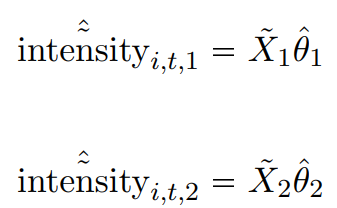

In [90]:
Image(filename = location + "\\FS_IV.png", width=250, height=100)

### FS Type 1

In [91]:
dummies_1 = pd.concat((pd.get_dummies(data_1['Year']), pd.get_dummies(data_1['ISO'])), axis=1).reset_index().drop(columns=["index"])

In [92]:
pr_tas_1 = pd.DataFrame()
pr_tas_1[theNames] = data_1polys

In [93]:
pr_tas_1_CTdummy = pd.concat((pr_tas_1, dummies_1), axis=1)

In [94]:
X_1_pt = pr_tas_1_CTdummy

In [95]:
Y_1_pt = data_1["Intensity"].reset_index().drop(columns=['index'])

In [96]:
model_1_pt = sm.OLS(Y_1_pt, X_1_pt)

In [97]:
results_1 = model_1_pt.fit()

In [130]:
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:              Intensity   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     4.186
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           1.07e-67
Time:                        19:58:33   Log-Likelihood:                 4549.3
No. Observations:                2199   AIC:                            -8643.
Df Residuals:                    1971   BIC:                            -7344.
Df Model:                         227                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

### FS Type 2

In [99]:
dummies_2 = pd.concat((pd.get_dummies(data_2['Year']), pd.get_dummies(data_2['ISO'])), axis=1).reset_index().drop(columns=["index"])

In [100]:
pr_tas_2 = pd.DataFrame()
pr_tas_2[theNames] = data_2polys

In [101]:
pr_tas_2_CTdummy = pd.concat((pr_tas_2, dummies_2), axis=1)

In [102]:
X_2_pt = pr_tas_2_CTdummy

In [103]:
Y_2_pt = data_2["Intensity"].reset_index().drop(columns=['index'])

In [104]:
model_2_pt = sm.OLS(Y_2_pt, X_2_pt)

In [105]:
results_2 = model_2_pt.fit()

In [131]:
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              Intensity   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     5.038
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           2.99e-48
Time:                        20:00:09   Log-Likelihood:                 597.52
No. Observations:                 700   AIC:                            -807.0
Df Residuals:                     506   BIC:                             75.86
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

# 1.3.2 Second Stage IV Regression

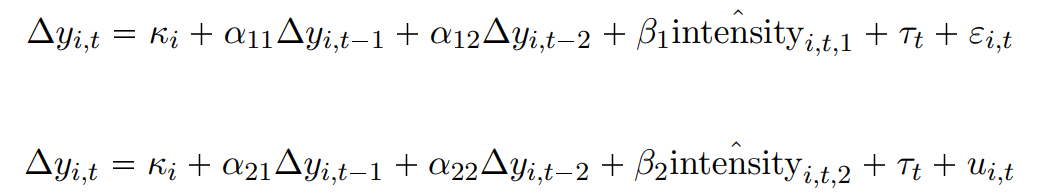

In [107]:
Image(filename = location + "\\SS_IV.png", width=800, height=100)

**Merging Data**

In [108]:
#Predicted values of intensity from FS
predy_1 = pd.DataFrame()
predy_1["pred_intensity"]= results_1.predict(X_1_pt)
# model_1.predict(X_1)

#Predicted values of intensity from FS
predy_2 = pd.DataFrame()
predy_2["pred_intensity"]= results_2.predict(X_2_pt)

In [109]:
#Type 1
SS_data_1 = pd.concat((data_1[["ln_GDP_diff_lag1", "ln_GDP_diff_lag2", "Year", "Income_Type"]],\
                    pd.get_dummies(data_1['Year']), pd.get_dummies(data_1['ISO'])), axis=1).reset_index()
SS_data_1 = pd.concat([predy_1, SS_data_1], axis=1).drop(columns=["index"])

#Type 2
SS_data_2 = pd.concat((data_2[["ln_GDP_diff_lag1", "ln_GDP_diff_lag2", "Year", "Income_Type"]],\
                    pd.get_dummies(data_2['Year']), pd.get_dummies(data_2['ISO'])), axis=1).reset_index()
SS_data_2 = pd.concat([predy_2, SS_data_2], axis=1).drop(columns=["index"])

In [110]:
#Splitting Type 1 by Income Type
SS_high_income_1 = SS_data_1[(SS_data_1["Income_Type"] == "High Income") | (SS_data_1["Income_Type"] == "Upper Middle Income")]
SS_low_income_1 = SS_data_1[(SS_data_1["Income_Type"] == "Low Income") | (SS_data_1["Income_Type"] == "Lower Middle Income")]


#Splitting Type 2 by Income Type
SS_high_income_2 = SS_data_2[(SS_data_2["Income_Type"] == "High Income") | (SS_data_2["Income_Type"] == "Upper Middle Income")]
SS_low_income_2 = SS_data_2[(SS_data_2["Income_Type"] == "Low Income") | (SS_data_2["Income_Type"] == "Lower Middle Income")]

### SS Type 1

**All Countries**

In [132]:
X_SS_1 = SS_data_1.drop(columns=["Year","Income_Type"])

Y_SS_1 = data_1["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [133]:
model_A1 = sm.OLS(Y_SS_1, X_SS_1).fit()

In [134]:
print(model_A1.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.174
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           4.64e-65
Time:                        20:02:00   Log-Likelihood:                 4043.5
No. Observations:                2199   AIC:                            -7653.
Df Residuals:                    1982   BIC:                            -6417.
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity      -0.0518      0.160  

**Rich Countries**

In [136]:
X_RSS_1 = SS_high_income_1.drop(columns=["Year","Income_Type"]).reset_index().drop(columns=["index"])

Y_RSS_1 = high_income_1["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [137]:
model_R1 = sm.OLS(Y_RSS_1, X_RSS_1).fit()

In [138]:
print(model_R1.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     4.505
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           5.00e-44
Time:                        20:03:26   Log-Likelihood:                 2127.6
No. Observations:                1035   AIC:                            -3971.
Df Residuals:                     893   BIC:                            -3269.
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity       0.0083      0.208  

**Poor Countries**

In [146]:
X_PSS_1 = SS_low_income_1.drop(columns=["Year","Income_Type"]).reset_index().drop(columns=["index"])

Y_PSS_1 = low_income_1["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [147]:
model_P1 = sm.OLS(Y_PSS_1, X_PSS_1).fit()

In [149]:
print(model_P1.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     3.319
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           6.74e-27
Time:                        20:09:33   Log-Likelihood:                 2018.1
No. Observations:                1164   AIC:                            -3770.
Df Residuals:                    1031   BIC:                            -3097.
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity      -0.0535      0.239  

### SS Type 2

**All Countries**

In [139]:
X_SS_2 = SS_data_2.drop(columns=["Year","Income_Type"])

Y_SS_2 = data_2["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [140]:
model = sm.OLS(Y_SS_2, X_SS_2)

In [141]:
model = model.fit()

In [142]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     3.106
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           9.64e-24
Time:                        20:06:41   Log-Likelihood:                 1442.4
No. Observations:                 700   AIC:                            -2519.
Df Residuals:                     517   BIC:                            -1686.
Df Model:                         182                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity      -0.0959      0.068  

**Rich Countries**

In [143]:
X_RSS_2 = SS_high_income_2.drop(columns=["Year","Income_Type"]).reset_index().drop(columns=["index"])

Y_RSS_2 = high_income_2["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [144]:
model_R2 = sm.OLS(Y_RSS_2, X_RSS_2).fit()

In [145]:
print(model_R2.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     5.620
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           5.72e-28
Time:                        20:07:41   Log-Likelihood:                 840.20
No. Observations:                 334   AIC:                            -1456.
Df Residuals:                     222   BIC:                            -1030.
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity       0.0691      0.089  

**Poor Countries**

In [127]:
X_PSS_2 = SS_low_income_2.drop(columns=["Year","Income_Type"]).reset_index().drop(columns=["index"])

Y_PSS_2 = low_income_2["ln_GDP_diff"].reset_index().drop(columns=["index"])

In [128]:
model_P2 = sm.OLS(Y_PSS_2, X_PSS_2).fit()

In [150]:
print(model_P2.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_GDP_diff   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1.983
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           3.67e-06
Time:                        20:10:41   Log-Likelihood:                 705.21
No. Observations:                 366   AIC:                            -1170.
Df Residuals:                     246   BIC:                            -702.1
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pred_intensity      -0.1588      0.099  